In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline

In [657]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [658]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

## Imputation of missing values ##

In [659]:

warnings.simplefilter('ignore', np.RankWarning)
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]

t = (x <= 25000) & (y <= 150) #Extract Values  
p = np.polyfit(x[t], y[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

There are many features were NaN should be considered as absence of such property. In other cases I replace NaN with most common value

In [660]:
all_data = all_data.fillna({
    'Alley' : 'NoAlley',
    'MasVnrType': 'None',
    'FireplaceQu': 'NoFireplace',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'BsmtQual' : 'NoBsmt',
    'BsmtCond' : 'NoBsmt',
    'BsmtExposure' : 'NoBsmt',
    'BsmtFinType1' : 'NoBsmt',
    'BsmtFinType2' : 'NoBsmt',
    'KitchenQual' : 'TA',
    'MSZoning' : 'RL',
    'Utilities' : 'AllPub',
    'Exterior1st' : 'VinylSd',
    'Exterior2nd'   : 'VinylSd',
    'Functional' : 'Typ',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'Electrical' : 'SBrkr'
     
})


all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0

# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()




## Normalization ##

In [661]:
# where we have order we will use numeric
all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},
                             'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'Fence': {'GdPrv': 2, 
                                       'GdWo': 2, 
                                       'MnPrv': 1, 
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}                             
                            })


all_data = all_data.replace({'CentralAir': {'Y': 1, 
                                            'N': 0}})
all_data = all_data.replace({'PavedDrive': {'Y': 1, 
                                            'P': 0,
                                            'N': 0}})


In [662]:
newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

In [663]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})




In [664]:
# The idea is good quality should rise price, poor quality - reduce price
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'

overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)



bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1


I have no idea what to do with Exterior1st, Exterior2nd, RoofMatl, Condition1, Condition2, BldgType. I'll try convert them into some kind of price brackets

In [665]:
from sklearn.svm import SVC
svm = SVC(C=100, gamma=0.0001, kernel='rbf')
pc = pd.Series(np.zeros(train.shape[0]))

pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
X_t = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)
svm.fit(X_t, pc) #Training
pc_pred = svm.predict(X_t)

p = train.SalePrice/100000

price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])
X_t = pd.get_dummies(all_data.loc[:, columns_for_pc], sparse=True)
pc_pred = svm.predict(X_t)
price_category[pc_pred=='pc2'] = 1
price_category[pc_pred=='pc3'] = 2

price_category = price_category.to_sparse()

In [666]:
# Monthes with the lagest number of deals may be significant
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

# Numer month is not significant
all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

In [667]:
reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])
reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1
reconstruct = reconstruct.to_sparse()

recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])
recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1
recon_after_buy = recon_after_buy.to_sparse()

build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])
build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1
build_eq_buy = build_eq_buy.to_sparse()

In [692]:
# I hope this will help
all_data.YrSold = 2010 - all_data.YrSold


0       0.0
1       0.5
2       0.0
3       1.0
4       0.0
5       0.5
6       0.5
7       0.5
8       0.0
9       0.0
10      0.0
11      1.0
12      0.0
13      0.5
14      0.0
15      0.5
16      1.0
17      1.0
18      0.0
19      0.5
20      1.0
21      0.5
22      0.0
23      0.5
24      1.0
25      0.5
26      1.0
27      1.0
28      1.0
29      0.0
       ... 
2889    1.0
2890    1.0
2891    1.0
2892    1.0
2893    1.0
2894    1.0
2895    1.0
2896    1.0
2897    1.0
2898    1.0
2899    1.0
2900    1.0
2901    1.0
2902    1.0
2903    1.0
2904    1.0
2905    1.0
2906    1.0
2907    1.0
2908    1.0
2909    1.0
2910    1.0
2911    1.0
2912    1.0
2913    1.0
2914    1.0
2915    1.0
2916    1.0
2917    1.0
2918    1.0
Name: YrSold, dtype: float64

In [669]:
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

In [670]:
all_data.YearBuilt = all_data.YearBuilt.map(year_map)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

Scaling numeric data

In [671]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

t = all_data[numeric_feats].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
all_data[use_max_scater] = all_data[use_max_scater]/all_data[use_max_scater].max()
all_data[use_95_scater] = all_data[use_95_scater]/all_data[use_95_scater].quantile(.95)

In [672]:
t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

## Preparing for sklearn##

In [673]:
# all classes in sklearn requires numeric data only
# transform categorical variable into binary
X = pd.get_dummies(all_data, sparse=True)
X = X.fillna(0)

In [674]:
X = X.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
X = X.drop('Condition2_PosN', axis=1) # only two is not zero
X = X.drop('MSZoning_C (all)', axis=1)
X = X.drop('MSSubClass_SubClass_160', axis=1)
# this features definitely couse overfitting

In [675]:
# add new features
X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,
               qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

Next step is guess what new feachers we need to intoduse to make the model better. I'll make a lot of feachers and model wiil choose

In [676]:
from itertools import product, chain

def poly(X):
    areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual', 'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x

XP = pd.concat(poly(X), axis=1)
X = pd.concat((X, XP), axis=1)

In [677]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [678]:
# the model has become really big
X_train.shape

(1460, 466)

In [679]:
y = np.log1p(train.SalePrice)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


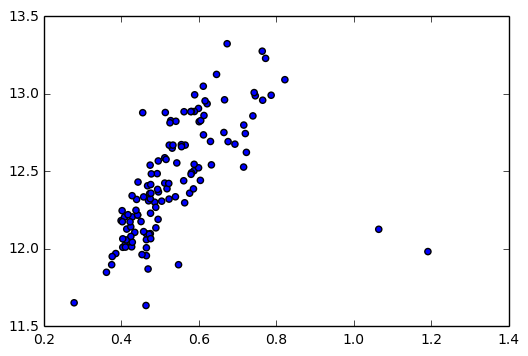

In [680]:
# this come from iterational model improvment. I was trying to understand why the model gives to the two points much better price
x_plot = X_train.loc[X_train['SaleCondition_Partial']==1, 'GrLivArea']
y_plot = y[X_train['SaleCondition_Partial']==1]
plt.scatter(x_plot, y_plot)

In [681]:
outliers_id = np.array([524, 1299])

outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
X_train = X_train.drop(outliers_id)
y = y.drop(outliers_id)
# There are difinetly more outliers

In [682]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

## Learning ##
The model is sparse with n_features > n_samples. Likely it's linear.  It is classic case to use the Lasso model

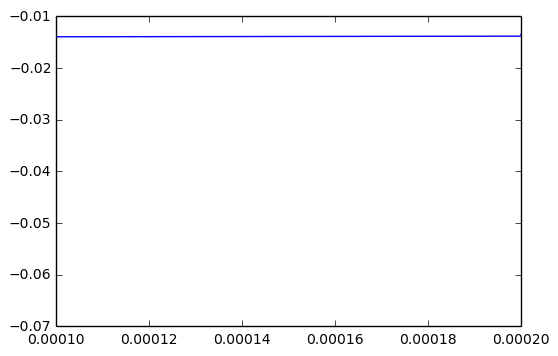

In [683]:
alphas = [1e-4, 5e-4, 1e-3, 5e-3, 5e-2, 2e-4]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

Choose alpha with better score

In [684]:
model_lasso = Lasso(alpha=5e-4, max_iter=50000).fit(X_train, y)

## Getting results##

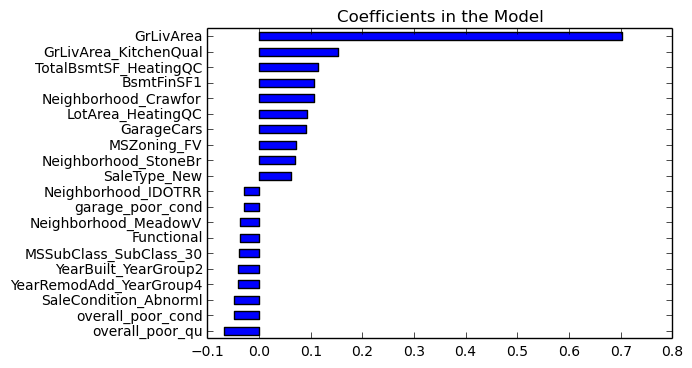

In [685]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

Some features still look suspicious. May be, we need to exlude them like RoofMatl_ClyTile and others

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


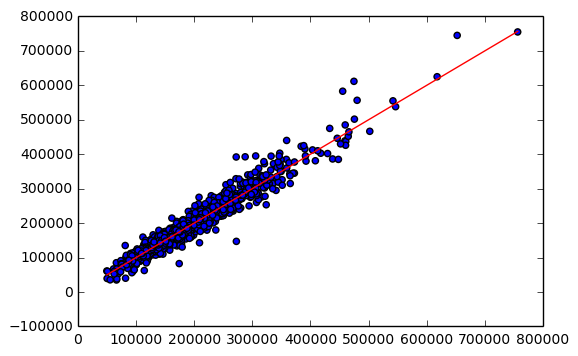

In [686]:
# This is a good way to see how model predict data
p_pred = np.expm1(model_lasso.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

Some point are far from the red line. May be they are outliers like the 524th and the 1299th

In [687]:
# save to file to make a submission
p = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("lasso_4Oct2.csv", index = False)

## Model improvement##
With various model tunnings I've got 0.11720 in public leaderboard. Ways of improvement are find some more outliers and exlude (or include) features.